In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = './'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

## Base Models

### Preprocessing

In [3]:
import pandas as pd
import numpy as np


train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

In [4]:

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [5]:
from fossil.preprocessing import FossilPreprocessor, LabelEncoder
from fossil.config import ModelsConfig

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95, random_state=ModelsConfig.SEED).unique())

fossil_preproc = FossilPreprocessor(sku_encoder)

In [6]:
base_data = fossil_preproc.prepare_primary_data(train_df)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

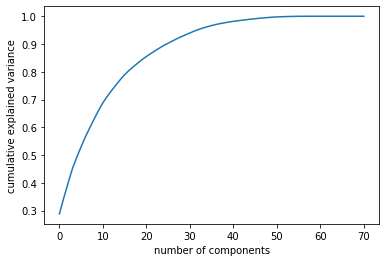

In [7]:
fossil_preproc.pca_feature_selection(base_data, eda=True)

In [8]:
principal_features = fossil_preproc.pca_feature_selection(base_data, 50)

### Training

In [9]:
from fossil.models.gbdt import FossilGBDT
gbdt_models = FossilGBDT()

oof_preds, cv_models, blended_mae = gbdt_models.blend_cv_models(principal_features, base_data, fossil_preproc)

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[239]	training's l1: 113999	valid_1's l1: 155863


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 88194.1	valid_1's l1: 118728
Early stopping, best iteration is:
[675]	training's l1: 79765	valid_1's l1: 117185


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 86117.6	valid_1's l1: 129252
Early stopping, best iteration is:
[673]	training's l1: 78092.4	valid_1's l1: 127827
Elapsed 0.18 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 83360.2	valid_1's l1: 150188
Early stopping, best iteration is:
[629]	training's l1: 77315.8	valid_1's l1: 148814


Training fold 2
Training until valid

## Inference

In [11]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [12]:
from fossil.inference import prepare_test_context
from fossil.config import ModelsConfig
from fossil.preprocessing import FossilPreprocessor, LabelEncoder

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())


fossil_preproc = FossilPreprocessor(sku_encoder)
test_context, test_dates = prepare_test_context(train_df, test, fossil_preproc)

In [13]:
feature_cols = [c for c in test_context.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

test_data = fossil_preproc.prepare_primary_data(test_context, True)

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [14]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [15]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

cols = principal_features+['month','year']
non_features = ['sku_name','sku_coded']+target_cols
feature_cols = [c for c in test_data.columns if c not in non_features and c in cols]

In [16]:
from fossil.inference import make_predictions

sub_df = make_predictions(test, test_data, feature_cols, target_cols, pred_cols, cv_models)

In [17]:
# save_name = f'{OUTPUT_DIR}/fossil_{ModelsConfig.BASE_MODEL}_{ModelsConfig.META_LEARNER}_{secondary_val_mae}.csv'
# sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [18]:
save_name = f'{OUTPUT_DIR}/fossil_blended_{blended_mae}.csv'
sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [19]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,preds_,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,35072.725079,0,51765.986180,66900.240234,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,44672.654183,1,82770.909699,72972.720703,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,43210.416403,2,92395.449753,77067.552734,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,56187.085045,3,83844.056748,90953.414062,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,68884.0,106365.0,129.0,129.0,633.0,159290.384286,0,216054.105895,236596.312500,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,211717.0,214756.0,129.0,129.0,248.0,207297.427046,3,223414.030279,226664.242188,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,180820.5,200574.0,149.0,149.0,1852.0,205218.138990,0,233358.549879,269986.476562,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,180820.5,200574.0,149.0,149.0,1852.0,196515.846253,1,235973.571477,265641.031250,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,180820.5,200574.0,149.0,149.0,1852.0,140360.727007,2,199853.100224,212035.796875,YOSHTLYNYOSHZZ_1_2022


In [21]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,preds_,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,35072.725079,0,43363.963964,66900.240234,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,44672.654183,1,69069.227243,72972.720703,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,43210.416403,2,77896.419235,77067.552734,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,-13675.5,-16208.0,149.0,149.0,74.0,56187.085045,3,72459.635888,90953.414062,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,68884.0,106365.0,129.0,129.0,633.0,159290.384286,0,187192.382883,236596.312500,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,211717.0,214756.0,129.0,129.0,248.0,207297.427046,3,207270.552980,226664.242188,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,180820.5,200574.0,149.0,149.0,1852.0,205218.138990,0,201965.760370,269986.476562,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,180820.5,200574.0,149.0,149.0,1852.0,196515.846253,1,207205.092680,265641.031250,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,180820.5,200574.0,149.0,149.0,1852.0,140360.727007,2,171106.706433,212035.796875,YOSHTLYNYOSHZZ_1_2022


In [18]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,35072.725079,0,47640.930020,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,44672.654183,1,77943.376682,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,43210.416403,2,87058.224649,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,56187.085045,3,79939.259651,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,159290.384286,0,203265.296056,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,207297.427046,3,223475.074890,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,205218.138990,0,220793.851680,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,196515.846253,1,223099.976004,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,140360.727007,2,189837.577327,YOSHTLYNYOSHZZ_1_2022
